In [1]:
from train import resnet_classification

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from classification_dataload import ClassificationDataset
from matplotlib import pyplot as plt
import util
import numpy
from collections import Counter

import importlib
from sklearn import metrics
rl = importlib.reload

In [2]:
target_category='species_binary'
model_ft, hist = resnet_classification(loading_model=True, model_name='resnet101_binary_300', target_category = target_category)

Loading customized pre-trained model


In [3]:
model_ft.eval()
image_root = 'image'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets = {x: ClassificationDataset(set_name=x, root_dir=image_root, target_category=target_category, flip_image=False)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                          shuffle=False, num_workers=6)
           for x in ['train', 'val', 'test']}

In [4]:
val_data = dataloaders['val']
train_data = dataloaders['train']
test_data = dataloaders['test']

dataset = val_data

In [5]:
classes = dataset.dataset.classes
maps = dataset.dataset.species_classes_map

In [6]:
len(dataset.dataset)

140

In [7]:
Counter(train_data.dataset.data_set_species)

Counter({'Animal': 694, 'Ghost': 410})

In [8]:
Counter(val_data.dataset.data_set_species)

Counter({'Animal': 91, 'Ghost': 49})

In [9]:
Counter(test_data.dataset.data_set_species)

Counter({'Animal': 89, 'Ghost': 49})

In [10]:
maps

{'Animal': 0, 'Ghost': 1}

In [ ]:
pred_list = []
actual_list = []
probablity_list = []
softmax = torch.nn.Softmax(dim=1)
misclassified_index = []

cam_trap = numpy.array(dataset.dataset.cam_trap)

with torch.no_grad():
    for image_index, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        actual_list += labels.tolist()

        outputs = model_ft(inputs)
        prob = softmax(outputs).tolist()
        probablity_list += prob
        
        _, preds = torch.max(outputs, 1)
        pred_list += preds.tolist()
        
        if any(preds != labels):
            misclassified_index += [image_index]
            util.imshow(inputs[preds != labels, :, :, :].cpu(), 
                        title=['validation image: {}, predicted: {} with probability {:.2f}% but actually: {}'.format(image_index, classes[int(preds[i])], max(prob[0])*100,classes[int(labels[i])]) 
                               for i in range(len(preds)) if labels[i] !=preds[i]],
                       savefig='savefig/validation_image_{}_camptrap_{}.png'.format(image_index, cam_trap[image_index]))

In [ ]:
Counter(numpy.array(dataset.dataset.cam_trap)[misclassified_index])

In [ ]:
Counter(numpy.array(dataset.dataset.cam_trap))

In [ ]:
sum(numpy.array(pred_list) != numpy.array(actual_list))

In [ ]:
metrics.confusion_matrix(y_true=actual_list, y_pred=pred_list).T

In [ ]:
metrics.precision_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

In [ ]:
metrics.recall_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

In [ ]:
metrics.accuracy_score(y_true=actual_list, y_pred=pred_list)

In [ ]:
metrics.f1_score(y_true=actual_list, y_pred=pred_list)

In [ ]:
lr_probs = numpy.array(probablity_list)[:,0]
testy = 1 - numpy.array(actual_list)


In [ ]:
rl(util)
util.roc(lr_probs, testy, savefig='savefig/roc_resnet50.png')

In [ ]:
rl(util)
util.prc(pred_list,lr_probs, testy, savefig='savefig/prc_resnet50.png')

In [ ]:
hist.keys()

In [ ]:
hist['train'].keys()

In [ ]:
hist['val'].keys()

In [ ]:
val_acc = [float(i) for i in hist['val']['epoch_acc']]
val_loss = [float(i) for i in hist['val']['epoch_loss']]

train_acc = [float(i) for i in hist['train']['epoch_acc']]
train_loss = [float(i) for i in hist['train']['epoch_loss']]

In [15]:
rl(util)

<module 'util' from 'C:\\Users\\liyex\\PycharmProjects\\camera-trap-imaging\\classification\\util.py'>

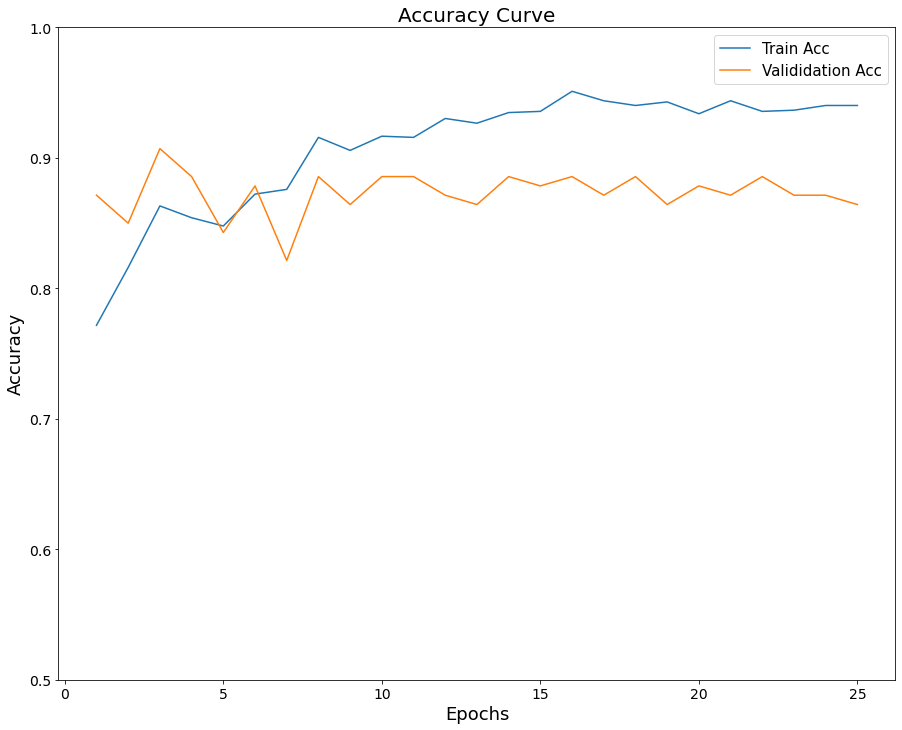

In [16]:
util.acc_curve(hist, savefig='binary_acc')

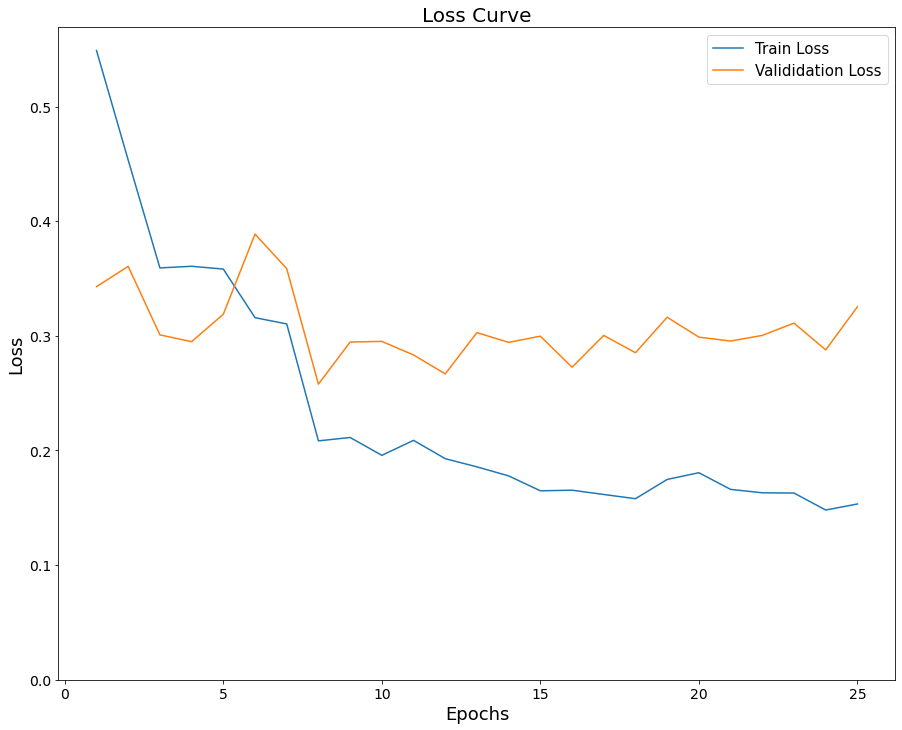

In [17]:
util.loss_curve(hist, savefig='binary_loss')